## Q5. Least-Squares Via JAX Autograd

In [1]:
# JAX + plotting niceties
%load_ext autoreload
%autoreload 2
%matplotlib inline

from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as onp

from autograder.reference.solution import (
    get_problem_data,
    least_squares_loss,
    lstsq_params_closed_form,
)

# -----------------------
# Load data
# -----------------------
data = onp.loadtxt("data/motor_data_large.csv", delimiter=",", skiprows=1)
current = jnp.asarray(data[:, 0])
torque = jnp.asarray(data[:, 1])

# -----------------------
# Normalize (fit in normalized space)
# -----------------------
eps = 1e-12

current_mean = jnp.mean(current)
current_std  = jnp.std(current) + eps

torque_mean = jnp.mean(torque)
torque_std  = jnp.std(torque) + eps

current_n = (current - current_mean) / current_std
torque_n  = (torque  - torque_mean)  / torque_std

A, y = get_problem_data(current_n, torque_n)

def unnormalize_params(
    params_n: jnp.ndarray,
    current_mean: jnp.ndarray,
    current_std: jnp.ndarray,
    torque_mean: jnp.ndarray,
    torque_std: jnp.ndarray,
) -> jnp.ndarray:
    """Convert quadratic model parameters back to raw units.

    Normalized model:
        torque_n = a_n + b_n * current_n + c_n * current_n^2

    Returns parameters [a, b, c] such that:
        torque ≈ a + b * current + c * current^2
    """
    a_n, b_n, c_n = params_n

    inv_std = 1.0 / current_std
    inv_std2 = inv_std * inv_std

    c = torque_std * c_n * inv_std2
    b = torque_std * (b_n * inv_std - 2.0 * c_n * current_mean * inv_std2)
    a = torque_mean + torque_std * (
        a_n
        - b_n * current_mean * inv_std
        + c_n * current_mean**2 * inv_std2
    )

    return jnp.array([a, b, c])


## Gradient descent in JAX

Here we'll implement basic gradient descent loop using two core JAX primitives and the `least_squares_loss` implemented in `solutions.py`:

- `jax.grad` to compute gradients
- `jax.lax.scan` to run an iterative update inside JIT-compiled code

Our goal is to show how to use JAX's autodiff and JIT compilation features to efficiently solve optimization problems.

### One gradient descent step

We first write the loss as a pure function of the parameters and data.  
Given this loss, a single gradient descent step is:
$$\theta \leftarrow \theta - \alpha \nabla_\theta \ell(\theta)$$
where $\alpha. > 0$ is the learning rate.


In JAX, this is implemented by differentiating the loss with `jax.grad`
and applying the update directly.

In [2]:
def grad_step(x: jnp.ndarray, A: jnp.ndarray, y: jnp.ndarray, lr: float) -> jnp.ndarray:
    g = jax.grad(least_squares_loss)(x, A, y)
    return x - lr * g

### Running the update loop with `jax.lax.scan`

Normally we would write gradient descent with a `for` loop in Python:

    for t in range(T):
        g = jax.grad(least_squares_loss)(params, A, y)
        params = params - lr * g
        losses.append(least_squares_loss(params, A, y))

But, in JAX, Python `for` loops do not compose well with `jax.jit`. Instead, we'll use
`jax.lax.scan`, which is a JAX-friendly way to express loops that can be JIT-compiled.

When using `jax.lax.scan`, each iteration of the loop has:

- a **state** carried from step to step (here: the parameters)
- an optional **output** recorded at each step (here: the loss)

Conceptually, the update looks like:

    params₀ → params₁ → params₂ → … → params_T
                 ↓        ↓            ↓
               loss₀    loss₁         loss_T

Using `scan` lets us run the entire optimization loop inside JAX’s compiled
computation graph, rather than unrolling it in Python.

In [3]:
@partial(jax.jit, static_argnames=["num_steps"])
def run_gd(A: jnp.ndarray, y: jnp.ndarray, x0: jnp.ndarray, lr: float, num_steps: int) -> tuple[jnp.ndarray, jnp.ndarray]:
    def body(x: jnp.ndarray, _: None) -> tuple[jnp.ndarray, jnp.ndarray]:
        loss = least_squares_loss(x, A, y)
        x = grad_step(x, A, y, lr)
        return x, loss

    x_final, losses = jax.lax.scan(body, x0, xs=None, length=num_steps)
    return x_final, losses

### Comparing gradient descent to the closed-form solution

We run gradient descent from an initial guess and compare the final loss
to the analytic least-squares solution. Both are computed in normalized
space; later we convert the parameters back to the original units for
interpretability.

In [4]:
lr = 1e-2
num_steps = 500
x0 = jnp.zeros((3,))

x_gd, losses = run_gd(A, y, x0, lr=lr, num_steps=num_steps)

loss_final_gd = least_squares_loss(x_gd, A, y)

# Compare gradient descent to closed-form solution.
x_star = lstsq_params_closed_form(A, y)  
loss_star = least_squares_loss(x_star, A, y)

print("normalized-space losses:")
print("  GD final loss:", float(loss_final_gd))
print("  closed-form loss:", float(loss_star))

x_star_unnorm = unnormalize_params(x_star, current_mean, current_std, torque_mean, torque_std)
x_gd_unnorm   = unnormalize_params(x_gd, current_mean, current_std, torque_mean, torque_std)

print("\noriginal-space params (for tau vs I):")
print("  closed-form:", onp.array(x_star_unnorm))
print("  GD:",         onp.array(x_gd_unnorm))

normalized-space losses:
  GD final loss: 0.018301576375961304
  closed-form loss: 0.018266530707478523

original-space params (for tau vs I):
  closed-form: [ 0.06929874  1.1030198  -0.01575398]
  GD: [ 0.11938953  1.0900004  -0.01532098]


### Plotting and analysis

Finally, we plot the loss over iterations to visualize convergence,
and visualize the model fit against the data from from both gradient descent and
the closed-form solution.

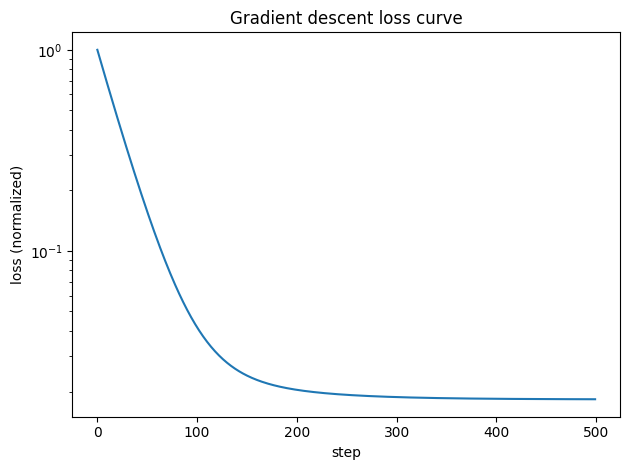

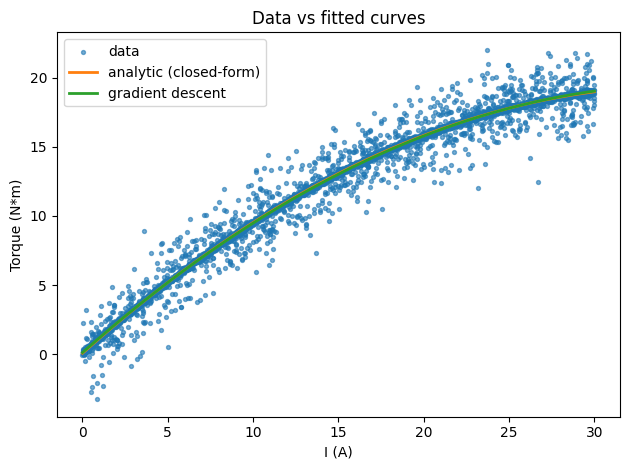

In [5]:
# -----------------------
# Plot: loss curve + unnormalized data with both fits
# -----------------------
losses_np = onp.asarray(losses)

plt.figure()
plt.plot(losses_np)
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("loss (normalized)")
plt.title("Gradient descent loss curve")
plt.tight_layout()

def predict(x_unnorm: jnp.ndarray, I_vals: jnp.ndarray) -> jnp.ndarray:
    a, b, c = x_unnorm
    return a + b * I_vals + c * (I_vals**2)

I_plot = onp.asarray(current)
tau_plot = onp.asarray(torque)

I_min, I_max = float(current.min()), float(current.max())
I_grid = jnp.linspace(I_min, I_max, 400)

tau_hat_star = predict(x_star_unnorm, I_grid)
tau_hat_gd   = predict(x_gd_unnorm,   I_grid)

plt.figure()
plt.scatter(I_plot, tau_plot, s=8, alpha=0.6, label="data")
plt.plot(onp.asarray(I_grid), 
         onp.asarray(tau_hat_star), 
         linewidth=2, 
         c="C1", 
         label="analytic (closed-form)")
plt.plot(onp.asarray(I_grid), 
         onp.asarray(tau_hat_gd),   
         linewidth=2, 
         c="C2", 
         label="gradient descent")
plt.xlabel("I (A)")
plt.ylabel("Torque (N*m)")
plt.title("Data vs fitted curves")

plt.legend()
plt.tight_layout()

plt.show()